In [1]:
#!pip install tensorflow==2.9.1

In [2]:

import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, \
Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

In [3]:
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)

        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)

            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)

    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(data_dir):

    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True,
                                          random_state=123, stratify=strat)

    # test dataframe
    strat = dummy_df['labels']
    valid_df, test_df= train_test_split(dummy_df, train_size=0.5, shuffle=True,
                                        random_state=123, stratify=strat)

    return train_df, valid_df, test_df

In [4]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    ''' Because the model uses data from the image data generator,
    this function takes the train, validation, and test dataframes
    and fits them into the picture data generator.
    Image data generator converts images into tensors. '''

    img_size = (150, 150)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in \
                                  range(1, ts_length + 1) if ts_length%n == 0 \
                                  and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function = scalar,
                                horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function = scalar)

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col = 'filepaths',
                                           y_col = 'labels',
                                           target_size = img_size,
                                           class_mode = 'categorical',
                                        color_mode = color, shuffle = True,
                                        batch_size = batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col = 'filepaths',
                                           y_col = 'labels',
                                           target_size = img_size,
                                           class_mode = 'categorical',
                                        color_mode = color, shuffle = True,
                                        batch_size = batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col = 'filepaths',
                                          y_col = 'labels',
                                          target_size = img_size,
                                          class_mode = 'categorical',
                                        color_mode = color, shuffle = False,
                                        batch_size = test_batch_size)

    return train_gen, valid_gen, test_gen

In [5]:
def show_images(gen):

    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 150
        plt.imshow((image * 150).astype('uint8'))
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'green', fontsize= 12)
        plt.axis('off')
    plt.show()

In [6]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

        # variables
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()


    def on_train_begin(self, logs= None):
        msg = 'Notification to halt training [y/n]?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs= None):

        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1
        else:
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

                else:
                    self.count = self.count + 1

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'Hit H to halt training, or enter an number of epochs to continue training'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'Training has been halted at epoch {epoch + 1}, as requested'
                        print(msg)
                        self.model.stop_training = True #

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' Training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

In [7]:
def plot_training(hist):

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('ggplot')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'b', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s = 100, c = 'red', label = loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'b', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s = 100, c = 'red', label = acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [8]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion Matrix', cmap = plt.cm.Reds):

	plt.figure(figsize = (10, 10))
	plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
    
	if normalize:
		cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment = 'center',
		         color = 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [9]:
data_dir = '/kaggle/input/curated-colon-dataset-for-deep-learning'

try:
    # Get splitted data
    train_df, valid_df, test_df = create_df(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid input')

Found 4200 validated image filenames belonging to 4 classes.
Found 900 validated image filenames belonging to 4 classes.
Found 900 validated image filenames belonging to 4 classes.


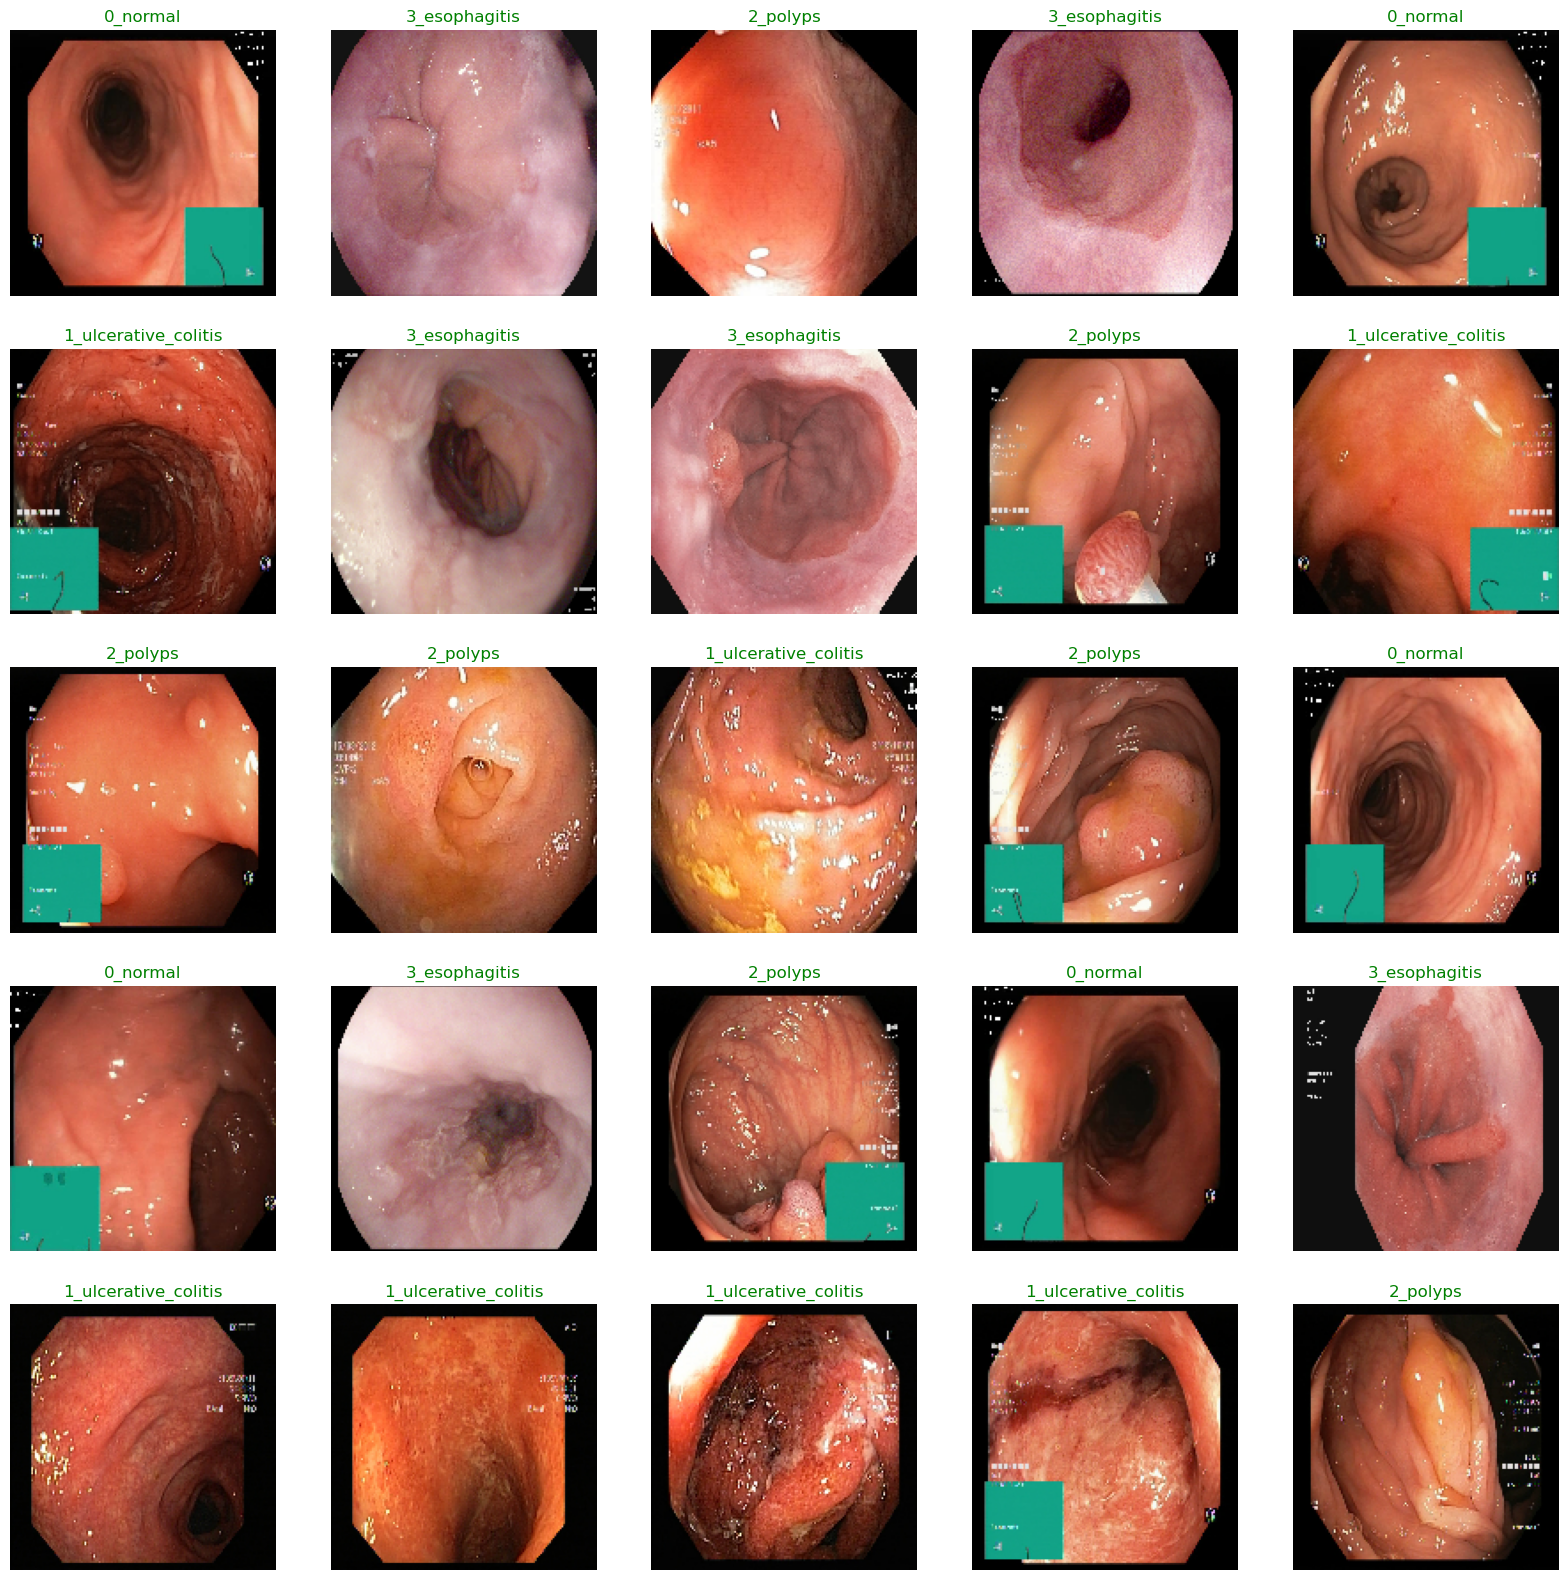

In [10]:
show_images(train_gen)

In [11]:
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


base_model = tf.keras.applications.efficientnet.EfficientNetB4(include_top = False,
                                                               weights = "imagenet",
                                                               input_shape = img_shape,
                                                               pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006),
           activation= 'relu'),
    Dropout(rate = 0.45, seed = 123),
    Dense(class_count, activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

71686520/71686520 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 batch_normalization (BatchN  (None, 1792)             7168      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               459008    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 18,141,027
Trainable params: 18,012,236
Non

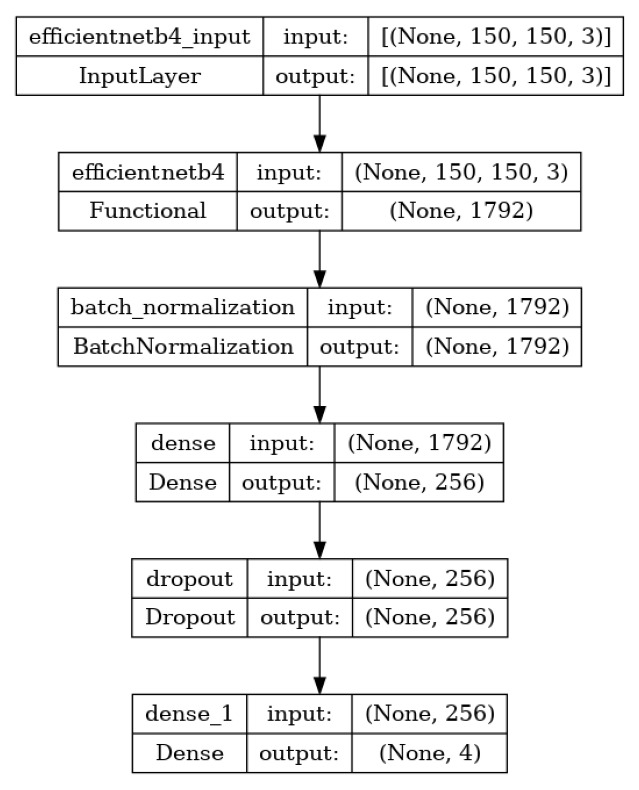

In [12]:
plot_model(model, show_shapes=True,
           show_layer_names=True,
           to_file='model_architecture.png')

image = plt.imread('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
batch_size = 40
epochs = 40
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
ask_epoch = 5
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model = model, patience = patience,
                        stop_patience = stop_patience,
                        threshold = threshold, factor= factor,
                        batches = batches, epochs = epochs,
                        ask_epoch= ask_epoch )]

In [ ]:
history = model.fit(x = train_gen, epochs = epochs, verbose = 0,
                    callbacks = callbacks, validation_data = valid_gen,
                    validation_steps = None, shuffle = False)

Notification to halt training [y/n]?


In [ ]:
import pickle
with open("colon_final.pkl", "wb") as file:
    pickle.dump(model, file)


In [ ]:
plot_training(history)

In [15]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps = test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps = test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps = test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

12/12 [==============================] - 14s 1s/step - loss: 0.1045 - accuracy: 0.9944
Train Loss:  0.09288077056407928
Train Accuracy:  1.0
--------------------
Validation Loss:  0.1155487447977066
Validation Accuracy:  0.9895833134651184
--------------------
Test Loss:  0.1044883131980896
Test Accuracy:  0.9944444298744202


In [16]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[1 1 3 0 2 1 1 2 3 3 2 3 0 3 2 3 2 0 1 2 2 1 1 3 2 2 3 2 1 3 1 1 2 3 1 2 2
 1 2 0 2 3 1 0 3 0 0 0 1 3 0 3 3 0 0 2 1 3 2 0 3 3 3 0 0 3 0 0 1 3 1 0 2 2
 2 2 0 1 3 3 1 1 3 2 2 3 2 1 1 0 3 2 2 1 2 2 3 1 1 1 3 2 2 1 2 2 1 0 3 3 1
 0 2 1 1 1 3 3 0 1 2 0 0 2 3 1 3 3 1 3 1 0 1 2 1 0 3 3 2 2 2 2 1 3 0 3 2 2
 2 0 0 3 2 3 2 1 0 2 3 3 0 3 1 1 2 0 2 0 0 1 2 1 0 3 3 0 3 2 0 0 2 3 3 3 2
 0 1 2 2 3 2 2 2 2 0 2 0 0 0 3 3 1 2 3 2 1 2 0 3 3 2 3 2 0 0 0 0 1 3 3 1 3
 3 3 2 3 0 1 1 1 1 3 3 2 2 3 0 2 3 0 0 2 0 3 3 2 0 2 2 0 3 3 2 1 1 3 1 2 3
 1 3 2 2 3 3 3 3 0 2 3 3 0 0 3 2 0 2 1 3 1 2 1 2 3 2 3 3 3 3 3 0 1 3 2 0 1
 1 0 0 0 0 2 3 1 2 2 2 0 3 3 1 2 1 3 2 1 3 2 1 0 0 0 3 1 3 1 2 1 2 2 3 2 1
 3 0 1 2 3 3 0 3 1 0 1 1 1 3 1 0 1 1 0 0 2 3 1 0 1 0 2 2 1 2 3 3 0 2 1 1 1
 2 0 0 2 3 2 3 2 1 1 2 2 2 1 0 2 3 3 2 3 1 2 2 3 3 0 2 1 1 0 1 1 3 1 1 1 3
 1 3 0 1 2 2 2 3 3 2 3 1 1 0 2 2 1 1 3 0 3 1 0 0 0 1 3 2 1 1 1 3 3 3 1 0 0
 2 2 3 1 0 3 1 2 1 1 3 3 1 2 1 0 1 2 1 1 2 0 0 2 1 3 1 0 0 3 1 1 0 2 2 2 2
 2 0 3 0 0 2 3 3 0 3 0 0 

Confusion Matrix, Without Normalization
[[224   1   0   0]
 [  0 224   1   0]
 [  0   2 222   1]
 [  0   0   0 225]]
                      precision    recall  f1-score   support

            0_normal       1.00      1.00      1.00       225
1_ulcerative_colitis       0.99      1.00      0.99       225
            2_polyps       1.00      0.99      0.99       225
       3_esophagitis       1.00      1.00      1.00       225

            accuracy                           0.99       900
           macro avg       0.99      0.99      0.99       900
        weighted avg       0.99      0.99      0.99       900



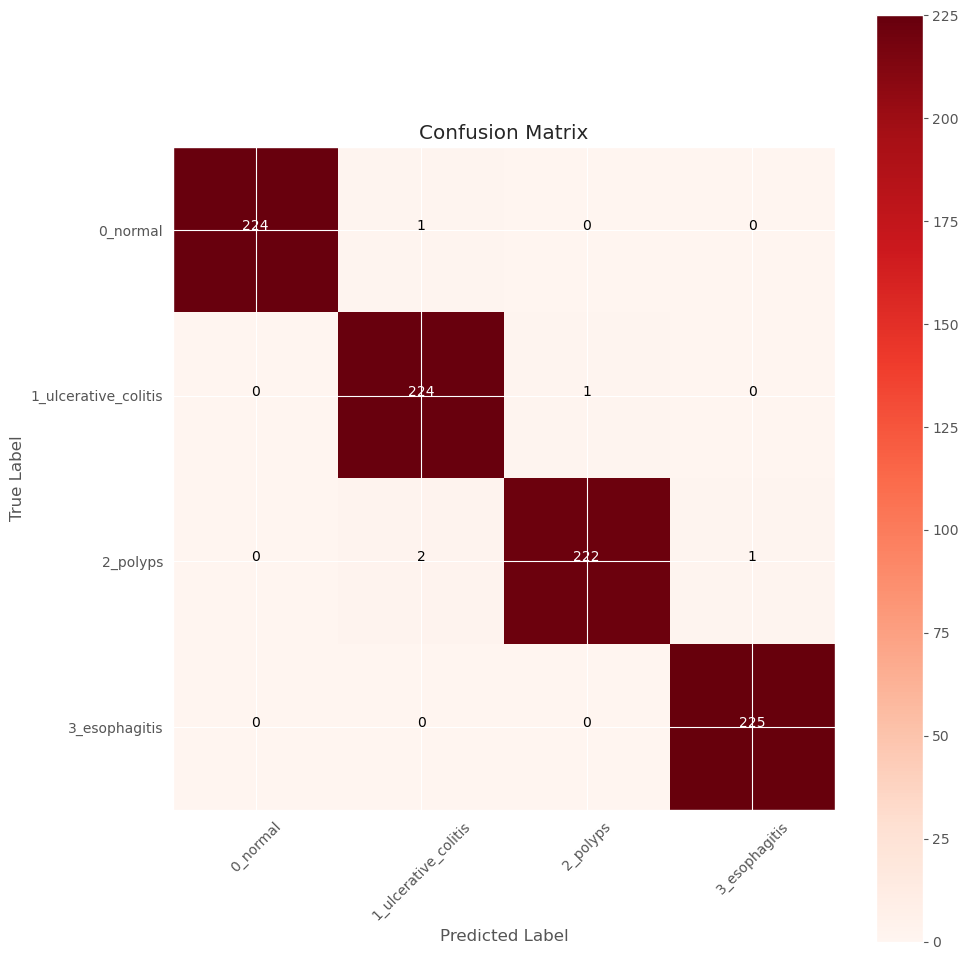

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm = cm, classes = classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names = classes))

In [18]:
#installing requirements file 
pip install -r requirements.txt

#To run flask server in local machine
python app.py

SyntaxError: invalid syntax (3976526311.py, line 2)

In [ ]:
#building docker image
docker build --tag colon-prediction

#forwarding the flask app port to docker
docker run -d -p 5000:5000 colon-prediction